In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as sts
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor as RF
from catboost import CatBoostRegressor as CAT
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor
from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.tree import DecisionTreeRegressor

In [2]:
%load_ext Cython

## Gradient Boosting Tree Ensemble Models
Some testing for my next notebook; <b>Gradient Boosting</b> w/ Regularisation & Bagging Approaches

In [3]:
%%cython -a 

import numpy as np
cimport numpy as np

# Regularised Model
cdef class Rtg:

    cdef public np.float64_t lamda, gamma, gain
    cdef public int bfeat_id, min_size, max_depth
    cdef public np.float64_t bfeat_val, value
    cpdef public Rtg lhs
    cpdef public Rtg rhs
    
    def __init__(self, int max_depth=3, np.float64_t lamda=1.0, np.float64_t gamma=0.1, min_size=5):
        self.max_depth = max_depth
        self.gamma = gamma; self.lamda = lamda
        self.lhs = None; self.rhs = None
        self.bfeat_id = -1 
        self.bfeat_val = 0 
        self.value = -7e10
        self.min_size = min_size
        
        return
    
    def fit(self, np.ndarray[np.float64_t, ndim=2] X, np.ndarray[np.float64_t, ndim=1] y):
        
        cpdef long ntot = X.shape[0]
        cpdef long SL = X.shape[0]
        cpdef long SR = 0
        cpdef long idx = 0
        cpdef long thres = 0
        cpdef np.float64_t GL, GR, gain
        cpdef np.ndarray[long, ndim=1] idxs
        cpdef np.float64_t x = 0.0
        cpdef np.float64_t best_gain = -self.gamma
        
        if self.value == -7e10:
            self.value = y.mean()
        if(self.max_depth <= 1):
            return
        
        error0 = ((y - self.value) ** 2).sum()
        error = error0; fid = 0
        n_feat = X.shape[1]
        left_value = 0; right_value = 0
        
        for feat in range(n_feat):
            
            idxs = np.argsort(X[:,feat])
            GL,GR = y.sum(),0.0
            SL,SR, thres = ntot, 0, 0
            
            while thres < ntot - 1:
                
                SL = SL - 1; SR = SR + 1
                idx = idxs[thres]
                x = X[idx, feat]
                
                GL = GL - y[idx]; GR = GR + y[idx]
                gain1 = (GL**2) / (SL + self.lamda)  + (GR**2) / (SR + self.lamda)
                gain2 = - ((GL + GR)**2) / (SL + SR + self.lamda) + self.gamma
                gain = gain1+gain2
                
                if thres < ntot - 1 and x == X[idxs[thres + 1], feat]:
                    thres += 1
                    continue
                
                if (gain > best_gain) and (min(SL,SR) > self.min_size):
                    
                    fid = 1
                    best_gain = gain
                    left_value = -GL / (SL + self.lamda)
                    right_value = -GR / (SR + self.lamda)
                    
                    self.bfeat_id = feat
                    self.bfeat_val = x

                thres += 1
        
        self.gain = best_gain
        if self.bfeat_id == -1:
            return
                
        self.lhs = Rtg(max_depth=self.max_depth - 1, gamma=self.gamma, lamda=self.lamda)
        self.rhs = Rtg(max_depth=self.max_depth - 1, gamma=self.gamma, lamda=self.lamda)
        self.lhs.value = left_value
        self.rhs.value = right_value

        idxs_l = (X[:, self.bfeat_id] > self.bfeat_val)
        idxs_r = (X[:, self.bfeat_id] <= self.bfeat_val)
        self.lhs.fit(X[idxs_l, :], y[idxs_l])
        self.rhs.fit(X[idxs_r, :], y[idxs_r])
        
        if (self.lhs.lhs == None or self.rhs.lhs == None):
            if self.gain < 0.0:
                self.lhs = None; self.rhs = None; self.bfeat_id = -1

    def ppredict(self, np.ndarray[np.float64_t, ndim=1] x):
        if self.bfeat_id == -1:
            return self.value
        if x[self.bfeat_id] > self.bfeat_val:
             return self.lhs.ppredict(x)
        else:
            return self.rhs.ppredict(x)
        
    def predict(self, np.ndarray[np.float64_t, ndim=2] X):
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self.ppredict(X[i])
            
        return y
    
# Bagging Model Regularised Model
class RtgBag():
    
    def __init__(self,min_size=5,max_depth=3,n_samples=10):
            
        self.max_depth = max_depth
        self.min_size = min_size
        self.n_samples = n_samples
        self.subsample_size = None
        self.lst_tree = [Rtg(min_size=self.min_size,max_depth=self.max_depth) for _ in range(self.n_samples)]
    
    def get_samples(self,X,y):

        i = np.random.randint(0, len(X), (self.n_samples, self.subsample_size))
        sampX = X[i]; sampy = y[i]
        return sampX, sampy
    
    def fit(self,X,y):
        
        ntot = X.shape[0]
        self.subsample_size = int(ntot)
        sampX, sampy = self.get_samples(X,y)
        for i in range(self.n_samples):
            self.lst_tree[i].fit(sampX[i], sampy[i].reshape(-1))
        return self
        
    def predict(self,X):
        
        mtot = X.shape[0]; pred = []
        for i in range(self.n_samples):
            pred.append(self.lst_tree[i].predict(X))
        pred = np.array(pred).T

        return np.array([np.mean(pred[i]) for i in range(mtot)])

In [4]:
from sklearn.base import BaseEstimator, RegressorMixin

# Gradient Boosting Model (XGB/XGB+Bagging)
class GBoost(BaseEstimator,RegressorMixin):
    
    def __init__(self, n_estimators=10, learning_rate=0.5, max_depth=3, 
                 n_samples = 15, min_size = 5, tree_id='xgb_bagging'):
            
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.min_size = min_size
        self.treem_id = []
        self.n_samples = n_samples
        self.tree_id = tree_id
        self.dm_depth = 1 
        self.mse_cond = 1.5 
    
    def fit(self, X, y):
        
        if(type(X) is not np.ndarray):
            X = X.values;
            y = y.values
        
        ntot = X.shape[0]
        self.X = X; self.y = y
        y0 = np.mean(y) * np.ones([ntot])
        prediction = y0.copy()
        prm1 = 1.1; prm2 = 1.5
        
        for t in range(self.n_estimators):
                        
            if t == 0:
                resid = y
            else:
                resid = (y - prediction)
                if (mse(temp_resid,resid) < self.mse_cond):
                    self.learning_rate = self.learning_rate/prm1
                    self.mse_cond = self.mse_cond/prm2
                    self.dm_depth = self.dm_depth+1
            
            d0 = self.min_size; d1 = self.max_depth+self.dm_depth
            if self.tree_id == 'xgb':
                submodel = Rtg(min_size=d0,max_depth=d1)
            if self.tree_id == 'xgb_bagging':
                submodel = RtgBag(min_size=d0,max_depth=d1,n_samples=self.n_samples)
                
            submodel.fit(X,-resid)
            y0 = submodel.predict(X).reshape([ntot])
            self.treem_id.append(submodel)
            prediction += self.learning_rate * y0
            temp_resid = -resid

        return self
    
    def predict(self, X):
        
        if(type(X) is not np.ndarray):
            X = X.values;
        
        mtot = X.shape[0]
        y_pred_gb = np.mean(self.y)*np.ones([mtot])
        for t in range(self.n_estimators):
            y_pred_gb += self.learning_rate * self.treem_id[t].predict(X).reshape([mtot])
            
        return y_pred_gb

## Evaluation & Test Regression Problem Functions 
- Standard Cross Validation & Evaluation scores extracted from Test Segments with no shuffling applied.
- Three common regression problems; <b>load_diabetes</b>,<b>California Housing</b> & <b>Boston Housing</b> Regression Problems.
- All comparison models were attempted to be compared at similar settings; Commonly used <b>XGB</b> library performs slightly worse, most likely due to setting setup only.

In [5]:
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

df_boston = sklearn_to_df(datasets.load_boston())
display(df_boston.head())

df_cali = sklearn_to_df(datasets.fetch_california_housing())
display(df_cali.head())

df_diab = sklearn_to_df(datasets.load_diabetes())
display(df_diab.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [6]:
from sklearn.model_selection import cross_val_score,cross_val_predict

def eval_kfold(ldf,feature='target',cv=5, model=None):
    
    # Split feature/target variable
    y = ldf[feature].copy()
    X = ldf.copy()
    del X[feature]     # remove target variable
    
    kf = KFold(n_splits=cv, shuffle=False)    
    X = X.values; y = y.values
#     score = np.sqrt(-cross_val_score(model,X,y,cv=kf,scoring='neg_mean_squared_error'))
#     predictions = cross_val_predict(model,X,y,cv=kf)  

    kf.get_n_splits(X)
    er_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        predict = model.predict(X_test)
        er_list.append(mse(y_test, predict))
        
#     return score
    return er_list

In [7]:
def eval_all(df=None,ncv=5,n_est=10,lr=0.5):

    
    err_bag = eval_kfold(ldf=df,cv=ncv,model=GBoost(n_estimators=n_est,tree_id='xgb_bagging',learning_rate=lr))
    err_xgb = eval_kfold(ldf=df,cv=ncv,model=GBoost(n_estimators=n_est,tree_id='xgb',learning_rate=lr))
    err_GDB = eval_kfold(ldf=df,cv=ncv,model=GBR(n_estimators=n_est,learning_rate=lr))
    err_XGB = eval_kfold(ldf=df,cv=ncv,model=XGBRegressor(n_estimators=n_est,learning_rate=lr))
    err_RF = eval_kfold(ldf=df,cv=ncv,model=RF(n_estimators=n_est))
    err_CAT = eval_kfold(ldf=df,cv=ncv,model=CAT(n_estimators=n_est,silent=True))
    err_ADA = eval_kfold(ldf=df,cv=ncv,model=AdaBoostRegressor(n_estimators=n_est,learning_rate=lr))
    err_BAG = eval_kfold(ldf=df,cv=ncv,model=BaggingRegressor(n_estimators=n_est))

    # Plots MSE errors
    data = [err_bag, err_xgb, err_GDB,err_XGB,err_RF,err_CAT,err_ADA,err_BAG]
    names = ['bag','xgb','GDB','XGB','RF','CAT','ADA','BAG']
    sns.set(style="whitegrid")
    fig,ax = plt.subplots(1,2,figsize=(14,4))
    sns.boxplot(data=data,ax=ax[0],orient="h",width=0.5,palette="Spectral")
    sns.stripplot(data=data,ax=ax[0], orient='h',color=".3",linewidth=0.3)
    ax[0].set_yticklabels(names);plt.show()
    
    ii=-1
    for i in data:
        ii+=1
        print(f'{names[ii]} : {sts.mean(data[ii]).round(3)} : {sts.stdev(data[ii])}')

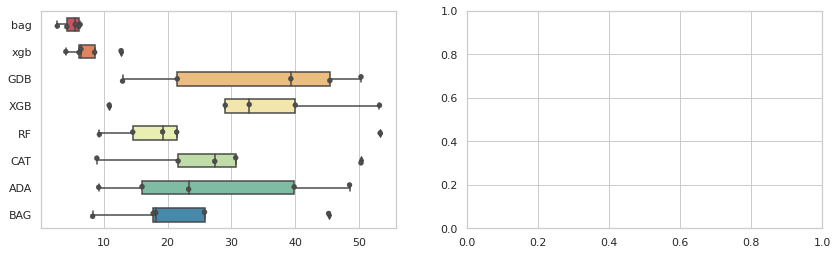

bag : 4.966 : 1.492034517673958
xgb : 7.574 : 3.285963587068345
GDB : 33.894 : 15.996826394225122
XGB : 33.174 : 15.516415340603984
RF : 23.555 : 17.263252314527424
CAT : 27.779 : 15.075279901706992
ADA : 27.361 : 16.41587755503639
BAG : 23.021 : 13.875374190515169


In [8]:
eval_all(df=df_boston,ncv=5,n_est=10,lr=1.0)

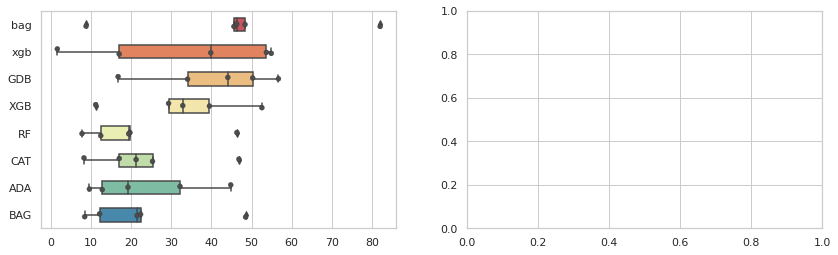

bag : 46.213 : 25.939078822148055
xgb : 33.414 : 23.428191362683663
GDB : 40.371 : 15.624449202972317
XGB : 33.083 : 15.13777018578539
RF : 21.119 : 14.961342237609262
CAT : 23.735 : 14.386273702022065
ADA : 23.719 : 14.625702384977144
BAG : 22.575 : 15.676561243033074


In [9]:
eval_all(df=df_boston,ncv=5,n_est=50,lr=1.0)

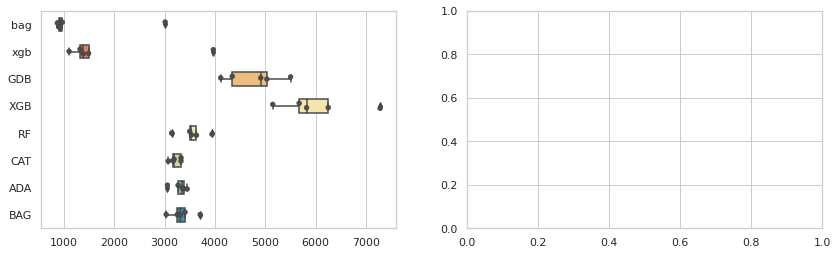

bag : 1332.604 : 938.9209844652084
xgb : 1852.718 : 1190.9401446441561
GDB : 4780.021 : 555.6024740032333
XGB : 6034.898 : 801.0627655624727
RF : 3548.318 : 287.9048854246315
CAT : 3216.521 : 109.0805203658383
ADA : 3300.024 : 151.29826489905025
BAG : 3341.387 : 246.48393324969905


In [10]:
eval_all(df_diab,ncv=5,n_est=10,lr=1.0)

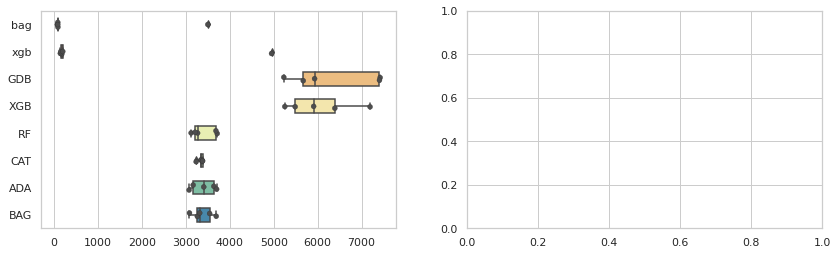

bag : 763.617 : 1528.3183886542924
xgb : 1120.94 : 2139.8824829537543
GDB : 6330.931 : 1019.8037194972492
XGB : 6045.212 : 774.0295404312037
RF : 3396.899 : 279.18907706426876
CAT : 3335.169 : 60.46082968663788
ADA : 3394.826 : 277.7363639909728
BAG : 3376.377 : 239.55112775846553


In [11]:
eval_all(df_diab,ncv=5,n_est=50,lr=1.0)

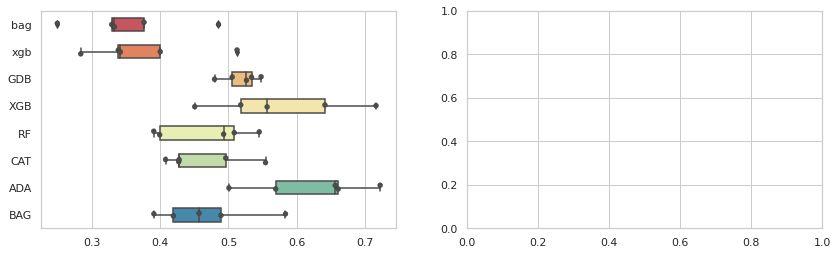

bag : 0.354 : 0.0864565197695753
xgb : 0.375 : 0.08727857388359457
GDB : 0.519 : 0.02670128205840492
XGB : 0.577 : 0.10436236011937608
RF : 0.467 : 0.06893957469122446
CAT : 0.462 : 0.061352220898114096
ADA : 0.622 : 0.08711655164999114
BAG : 0.468 : 0.07474338112143211


In [12]:
eval_all(df_cali,ncv=5,n_est=10,lr=1.0)

## Conclusions 
- The current tree based ensemble regressor class setup is quite favourable when it comes to solution accuracy, outperforming other libraries in the process for multiple problems when using similar hyperparameter setups.
- The bagging ensemble xgb model perfomed better than the baseline xgb in all cases, even with the default bagging parameter settings.
- Some interesting additions to the current class would definitely be the integration of GPU compatible internal calculations.
- Regardless of the superiority of the current results, the current results don't quite give a full picture when it comes to performance evaluation, particularly speed & gridsearch comparisons are not included, and would be beneficial to compare.